# Let's start with imporing the necessary libraries:

In [89]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
warnings.filterwarnings("ignore")

#use the following commands if some of the modules are not installed:
#conda install joblib
#conda install -c conda-forge imbalanced-learn

# Split the data into two: 60% of clients for who we know the outcome and 40% of clients that we are going to use for making predictions:

In [90]:
#import data from the file
Soc_Dem = pd.read_excel('~/Desktop/DMML_Project_Dataset.xlsx', sheet_name="Soc_Dem")
Act_Prod = pd.read_excel('~/Desktop/DMML_Project_Dataset.xlsx', sheet_name="Products_ActBalance")
Flow = pd.read_excel('~/Desktop/DMML_Project_Dataset.xlsx', sheet_name="Inflow_Outflow")
Sales_Rev = pd.read_excel('~/Desktop/DMML_Project_Dataset.xlsx', sheet_name="Sales_Revenues")

#join the tables
Soc_Dem = Soc_Dem.sort_values(by=['Client'])
Act_Prod = Act_Prod.sort_values(by=['Client'])
Flow = Flow.sort_values(by=['Client'])
Sales_Rev = Sales_Rev.sort_values(by=['Client'])

merge_1 = pd.merge(Soc_Dem, Act_Prod, how='left', on=['Client'])
merge_2 = pd.merge(merge_1, Flow, how='left', on=['Client'])
final = pd.merge(merge_2, Sales_Rev, how='left', on=['Client'])

#create a set for 60% of clients in the dataset which will be used for training models (we know outcome for these clients)
main_right = pd.merge(Flow, Sales_Rev, how='right', on=['Client'])
main = pd.merge (merge_1, main_right, how = 'right', on = ['Client'])

#create a set for 40% of clients in the dataset which will be used for predicting 100 customers
predict = pd.concat([final,main],ignore_index=True)
predict = predict.drop_duplicates(subset='Client',keep=False)

#set Client column as an index:
main.set_index('Client', inplace=True)
predict.set_index('Client', inplace=True)

print(main.shape)
print(predict.shape) #we set aside this DF

(969, 35)
(646, 35)


# Data preparation for future modelling. Handling missing values and dealing with categorical values.

In [91]:
#We have quite many missing values. It's time to theat them.

#First, impute the 2 missing Sex variables with the most common category
main['Sex'].fillna(main['Sex'].value_counts().index[0], inplace=True)

#Second, replace all the NaN values with zero values
main = main.replace(np.nan, 0)

#Now we need to replace categories with dummy variables.

#create dummy variables for Sex feature
sex_dummies = pd.get_dummies(main['Sex'])
main = pd.concat([sex_dummies, main], axis = 1)

#get observations for which column Age has value lower than 18
#get observations for customers who did not accept MF offer 
#since we are applying our model only to those customers who are most likely to accept the offer, we drop those with Sale_MF = 0

drop  = main[(main['Sale_MF'] == 0) | (main['Age'] < 18)].index

# Delete these rows from dataFrame
main = main.drop(drop)
main.head()

,F,M,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,...,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
Client,,,,,,,,,,,,,,,,,,,,,
1,1,0,F,51,7,1,0.0,0.0,1.0,0.0,...,30.0,3.0,12.0,9.0,1,0,0,26.972679,0.0,0.0
27,0,1,M,62,181,1,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1,0,0,220.488214,0.0,0.0
34,1,0,F,48,104,1,1.0,3.0,1.0,1.0,...,19.0,6.0,33.0,11.0,1,0,0,0.601071,0.0,0.0
36,1,0,F,49,263,1,1.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1,0,0,0.238036,0.0,0.0
42,0,1,M,23,4,1,0.0,12.0,0.0,0.0,...,9.0,1.0,1.0,6.0,1,0,0,15.275714,0.0,0.0


In [92]:
#drop columns with more than 70% of zeroes:
main = main.drop(["Count_SA","Count_MF","Count_OVD","Count_CC",
                   "Count_CL","ActBal_MF","ActBal_SA","ActBal_OVD","ActBal_CC","ActBal_CL", 'Sex'],axis=1)

# Feature scaling and normalisation:

In [93]:
#We choose the same features as for classification as they are not correlated:
x = main['Age']
x1 = main['Tenure']
x2 = main['ActBal_CA']
x3 = main['VolumeCred']
x4 = main['VolumeDebCashless_Card']

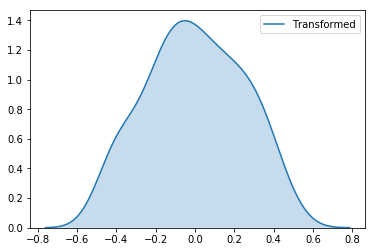

In [94]:
#x = main['Age']:

#add 0.01 in case an observation is equal to zero:
x = x + 0.01

#Box Cox Transformation helps to normalise the data:
xt, maxlog, interval = stats.boxcox(x, alpha = 0.05)

#Min-max scaling scales the data between 0 and 1:
xt = (xt-xt.mean())/(xt.max()-xt.min())
sns.kdeplot(xt, shade=True, label="Transformed");

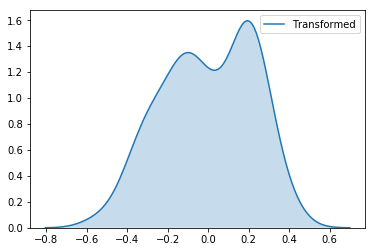

In [95]:
#x1 = main['Tenure']:
    
x1 = x1 + 0.01
xt1, maxlog, interval = stats.boxcox(x1, alpha=0.05)
xt1 = (xt1-xt1.mean())/(xt1.max()-xt1.min())
sns.kdeplot(xt1, shade=True, label="Transformed");

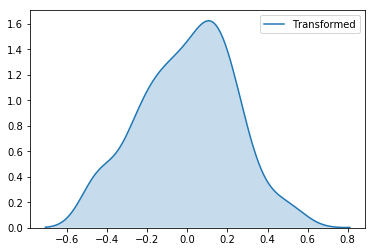

In [96]:
#x2 = main['ActBal_CA']:

x2 = x2 + 0.01
xt2, maxlog, interval = stats.boxcox(x2, alpha=0.05)
xt2 = (xt2-xt2.mean())/(xt2.max()-xt2.min())
sns.kdeplot(xt2, shade=True, label="Transformed");

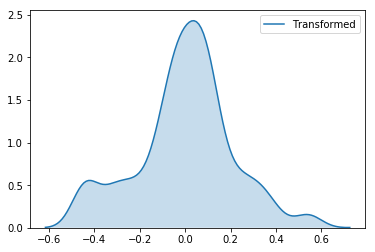

In [97]:
#x3 = main['VolumeCred']:
    
x3 = x3 + 0.01
xt3, maxlog, interval = stats.boxcox(x3, alpha=0.05)
xt3 = (xt3-xt3.mean())/(xt3.max()-xt3.min())
sns.kdeplot(xt3, shade=True, label="Transformed");

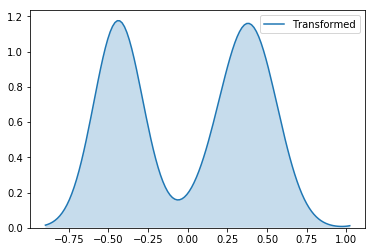

In [98]:
#x4 = main['VolumeDebCashless_Card']:
    
x4 = x4 + 0.01
xt4, maxlog, interval = stats.boxcox(x4, alpha=0.05)
xt4 = (xt4-xt4.mean())/(xt4.max()-xt4.min())
sns.kdeplot(xt4, shade=True, label="Transformed");

In [99]:
#join transformed variables into a new DataFrame:

Tmain_ML = pd.DataFrame()
Tmain_ML['M'] = main['M']
Tmain_ML['F'] = main ['F']
Tmain_ML['Age'] = xt
Tmain_ML['Tenure'] = xt1
Tmain_ML['Count_CA'] = main['Count_CA']
Tmain_ML['ActBal_CA'] = xt2
Tmain_ML['VolumeCred'] = xt3
Tmain_ML['VolumeDebCashless_Card'] = xt4

In [100]:
Tmain_ML.columns

Index(['M', 'F', 'Age', 'Tenure', 'Count_CA', 'ActBal_CA', 'VolumeCred',
       'VolumeDebCashless_Card'],
      dtype='object')

# Solit data into test and train:

In [101]:
#assign the transformed independent variables to X:
X = Tmain_ML[['M', 'F', 'Age', 'Tenure', 'Count_CA', 'ActBal_CA', 'VolumeCred',
       'VolumeDebCashless_Card']]

#assign target variables to y:
y = main[['Revenue_MF']]

print(X.shape)
print(y.shape)

(182, 8)
(182, 1)


In [102]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)


#fit linear regression to the train data
lr = LinearRegression().fit(X_train, y_train)

#predict test set results
y_test_pred = lr.predict(X_test)

#predict accuracy score, coefficients for each independent variable and intercept:
print(lr.score(X_test, y_test))
print(lr.coef_)
print(lr.intercept_)

-0.3076012545806195
[[ 2.54584389e+00 -2.54584389e+00  1.39617370e+01 -5.19758824e+00
  -1.09814396e-02 -5.07827793e-01  1.74504142e+01 -9.22251053e+00]]
[9.94937729]


In [103]:
from sklearn.model_selection import cross_val_predict  # For K-Fold Cross Validation
from sklearn.metrics import r2_score  # For find accuracy with R2 Score
from sklearn.metrics import mean_squared_error  # For MSE
from math import sqrt  # For squareroot operation

# Multiple Linear Regression

In [104]:
#Time to apply models to our data:
from sklearn.linear_model import LinearRegression  # Import Linear Regression model

MLR = LinearRegression()  # Create a instance for Linear Regression model
MLR.fit(X_train, y_train)  # Fit data to the model


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [105]:
# Prediction with training dataset:
y_pred_MLR_train = MLR.predict(X_train)

# Prediction with testing dataset:
y_pred_MLR_test = MLR.predict(X_test)

# Find training accuracy for this model:
accuracy_MLR_train = r2_score(y_train, y_pred_MLR_train)
print("Training Accuracy for MLR Model: ", accuracy_MLR_train)

# Find testing accuracy for this model:
accuracy_MLR_test = r2_score(y_test, y_pred_MLR_test)
print("Testing Accuracy for MLR Model: ", accuracy_MLR_test)

# Find RMSE (root mean square error) for training data:
RMSE_MLR_train = sqrt(mean_squared_error(y_train, y_pred_MLR_train))
print("RMSE for Training Data: ", RMSE_MLR_train)

# Find RMSE for testing data:
RMSE_MLR_test = sqrt(mean_squared_error(y_test, y_pred_MLR_test))
print("RMSE for Testing Data: ", RMSE_MLR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_MLR = cross_val_predict(MLR, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_MLR = r2_score(y, y_pred_cv_MLR)
print("Accuracy for 10-Fold Cross Predicted MLR Model: ", accuracy_cv_MLR)


Training Accuracy for MLR Model:  0.07240595083334778
Testing Accuracy for MLR Model:  -0.3076012545806195
RMSE for Training Data:  21.94171229468083
RMSE for Testing Data:  16.44721737137379
Accuracy for 10-Fold Cross Predicted MLR Model:  -0.08996974329736762


# Polynomial Features

In [106]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_features = PolynomialFeatures(degree=3)  
x_train_poly = polynomial_features.fit_transform(X_train)  # Fit and transform the training data to polynomial
x_test_poly = polynomial_features.fit_transform(X_test)  # Fit and transform the testing data to polynomial

PR = LinearRegression(fit_intercept=False)  
PR.fit(x_train_poly, y_train)  

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None,
         normalize=False)

In [107]:
# Prediction with training dataset:
y_pred_PR_train = PR.predict(x_train_poly)

# Prediction with testing dataset:
y_pred_PR_test = PR.predict(x_test_poly)

# Find training accuracy for this model:
accuracy_PR_train = r2_score(y_train, y_pred_PR_train)
print("Training Accuracy for Polynomial Regression Model: ", accuracy_PR_train)

# Find testing accuracy for this model:
accuracy_PR_test = r2_score(y_test, y_pred_PR_test)
print("Testing Accuracy for Polynomial Regression Model: ", accuracy_PR_test)

# Find RMSE for training data:
RMSE_PR_train = sqrt(mean_squared_error(y_train, y_pred_PR_train))
print("RMSE for Training Data: ", RMSE_PR_train)

# Find RMSE for testing data:
RMSE_PR_test = sqrt(mean_squared_error(y_test, y_pred_PR_test))
print("RMSE for Testing Data: ", RMSE_PR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_PR = cross_val_predict(PR, polynomial_features.fit_transform(X), y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_PR = r2_score(y, y_pred_cv_PR)
print("Accuracy for 10-Fold Cross Predicted Polynomial Regression Model: ", accuracy_cv_PR)


Training Accuracy for Polynomial Regression Model:  0.8785704488489543
Testing Accuracy for Polynomial Regression Model:  -3.0358030740565782
RMSE for Training Data:  7.938779400511316
RMSE for Testing Data:  28.89480389580796
Accuracy for 10-Fold Cross Predicted Polynomial Regression Model:  -0.8128482116782321


In [108]:
from sklearn.model_selection import cross_val_predict  # For K-Fold Cross Validation
from sklearn.metrics import r2_score  # For find accuracy with R2 Score
from sklearn.metrics import mean_squared_error  # For MSE
from math import sqrt  # For squareroot operation


# Decision Tree

In [109]:
from sklearn.tree import DecisionTreeRegressor  

DTR = DecisionTreeRegressor( random_state = 13)  
DTR.fit(X_train, y_train) 

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=13, splitter='best')

In [110]:
#Apply GridSearch to find best hyperparameters.

from sklearn.model_selection import GridSearchCV
param_grid = {
        'max_leaf_nodes': list(range(2, 100)), 
        'min_samples_split': [2, 3, 4]
        }

#Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(DTR, param_grid=param_grid)

#Fit data to grid_model
grid_model_result = grid_model.fit(X_train, y_train)

#Summarize results
best_params = grid_model_result.best_params_
best_score = grid_model_result.best_score_
print("Best: %f using %s" % (best_score, best_params))

Best: -0.058830 using {'max_leaf_nodes': 4, 'min_samples_split': 2}


In [111]:
DTR = DecisionTreeRegressor( max_depth = 3,max_leaf_nodes = 2, min_samples_split = 2, random_state = 13)  
DTR.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=2, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=13, splitter='best')

In [112]:
# Prediction with training dataset:
y_pred_DTR_train = DTR.predict(X_train)

# Prediction with testing dataset:
y_pred_DTR_test = DTR.predict(X_test)

# Find training accuracy for this model:
accuracy_DTR_train = r2_score(y_train, y_pred_DTR_train)
print("Training Accuracy for Decision Tree Regression Model: ", accuracy_DTR_train)

# Find testing accuracy for this model:
accuracy_DTR_test = r2_score(y_test, y_pred_DTR_test)
print("Testing Accuracy for Decision Tree Regression Model: ", accuracy_DTR_test)

# Find RMSE for training data:
RMSE_DTR_train = sqrt(mean_squared_error(y_train, y_pred_DTR_train))
print("RMSE for Training Data: ", RMSE_DTR_train)

# Find RMSE for testing data:
RMSE_DTR_test = sqrt(mean_squared_error(y_test, y_pred_DTR_test))
print("RMSE for Testing Data: ", RMSE_DTR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_DTR = cross_val_predict(DTR, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_DTR = r2_score(y, y_pred_cv_DTR)
print("Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model: ", accuracy_cv_DTR)


Training Accuracy for Decision Tree Regression Model:  0.1611987865205199
Testing Accuracy for Decision Tree Regression Model:  -0.5397180130829144
RMSE for Training Data:  20.865128528987608
RMSE for Testing Data:  17.84741668321756
Accuracy for 10-Fold Cross Predicted Decision Tree Regression Model:  -0.07179302421202038


# Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor  

RFR = RandomForestRegressor(n_estimators=1000, max_depth=5, random_state=13, max_features = 'sqrt')  
RFR.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=13, verbose=0, warm_start=False)

In [114]:
from sklearn.model_selection import GridSearchCV
param_grid = {
            'n_estimators': [200, 700, 800, 1000],
            'max_features': ['auto', 'sqrt', 'log2']
            }

#Instantiate GridSearchCV with the required parameters
grid_model = GridSearchCV(RFR, param_grid=param_grid)

#Fit data to grid_model
grid_model_result = grid_model.fit(X_train, y_train)

#Summarize results
best_params = grid_model_result.best_params_
best_score = grid_model_result.best_score_
print("Best: %f using %s" % (best_score, best_params))


Best: -0.547258 using {'max_features': 'sqrt', 'n_estimators': 700}


In [115]:
# Prediction with training dataset:
y_pred_RFR_train = RFR.predict(X_train)

# Prediction with testing dataset:
y_pred_RFR_test = RFR.predict(X_test)

# Find training accuracy for this model:
accuracy_RFR_train = r2_score(y_train, y_pred_RFR_train)
print("Training Accuracy for Random Forest Regression Model: ", accuracy_RFR_train)

# Find testing accuracy for this model:
accuracy_RFR_test = r2_score(y_test, y_pred_RFR_test)
print("Testing Accuracy for Random Forest Regression Model: ", accuracy_RFR_test)

# Find RMSE for training data:
RMSE_RFR_train = sqrt(mean_squared_error(y_train, y_pred_RFR_train))
print("RMSE for Training Data: ", RMSE_RFR_train)

# Find RMSE for testing data:
RMSE_RFR_test = sqrt(mean_squared_error(y_test, y_pred_RFR_test))
print("RMSE for Testing Data: ", RMSE_RFR_test)

# Prediction with 10-Fold Cross Validation:
y_pred_cv_RFR = cross_val_predict(RFR, X, y, cv=10)

# Find accuracy after 10-Fold Cross Validation
accuracy_cv_RFR = r2_score(y, y_pred_cv_RFR)
print("Accuracy for 10-Fold Cross Predicted Random Forest Regression Model: ", accuracy_cv_RFR)


Training Accuracy for Random Forest Regression Model:  0.7525699779282307
Testing Accuracy for Random Forest Regression Model:  -0.3491532016319314
RMSE for Training Data:  11.332291470627746
RMSE for Testing Data:  16.706497193814357
Accuracy for 10-Fold Cross Predicted Random Forest Regression Model:  -0.02999490546690553


In [116]:
#Compare all results in one table
training_accuracies = [accuracy_MLR_train, accuracy_PR_train, accuracy_DTR_train, accuracy_RFR_train]
testing_accuracies = [accuracy_MLR_test, accuracy_PR_test, accuracy_DTR_test, accuracy_RFR_test]
training_RMSE = [RMSE_MLR_train, RMSE_PR_train, RMSE_DTR_train, RMSE_RFR_train]
testing_RMSE = [RMSE_MLR_test, RMSE_PR_test, RMSE_DTR_test, RMSE_RFR_test]
cv_accuracies = [accuracy_cv_MLR, accuracy_cv_PR, accuracy_cv_DTR, accuracy_cv_RFR]

parameters = ["fit_intercept=False", "fit_intercept=False", "max_depth=5", "n_estimators=400, max_depth=5"]

table_data = {"Parameters": parameters, "Training Accuracy": training_accuracies, "Testing Accuracy": testing_accuracies, 
              "Training RMSE": training_RMSE, "Testing RMSE": testing_RMSE, "10-Fold Score": cv_accuracies}
model_names = ["Multiple Linear Regression", "Polynomial Regression", "Decision Tree Regression", "Random Forest Regression"]

table_dataframe = pd.DataFrame(data=table_data, index=model_names)
table_dataframe

,Parameters,Training Accuracy,Testing Accuracy,Training RMSE,Testing RMSE,10-Fold Score
Multiple Linear Regression,fit_intercept=False,0.072406,-0.307601,21.941712,16.447217,-0.089970
Polynomial Regression,fit_intercept=False,0.878570,-3.035803,7.938779,28.894804,-0.812848
Decision Tree Regression,max_depth=5,0.161199,-0.539718,20.865129,17.847417,-0.071793
Random Forest Regression,"n_estimators=400, max_depth=5",0.752570,-0.349153,11.332291,16.706497,-0.029995


# Prepare data set for prediction the same way we prepared train set:

In [117]:
#First, impute the 2 missing Sex variables with the most common category
predict['Sex'].fillna(predict['Sex'].value_counts().index[0], inplace=True)

#Second, replace all the NaN values with zero values
predict = predict.replace(np.nan, 0)

#Now we need to replace categories with dummy variables.
#create dummy variables for Sex feature
sex_dummies = pd.get_dummies(predict['Sex'])
predict = pd.concat([sex_dummies, predict], axis = 1)

# Get observations for which column Age has value lower than 18
#under18 = predict[predict['Age'] < 18].index

# Delete these rows from dataFrame
#predict = predict.drop(under18)
predict.shape


(646, 37)

In [118]:
predict = predict[[ 'M', 'F', 'Age', 'Tenure', 'Count_CA', 'ActBal_CA', 'VolumeCred',
       'VolumeDebCashless_Card']]

In [119]:
#Upload the dataset of people from classification problem (most likely to accept MF offer).
contact_MF = pd.read_csv('~/Desktop/contact_MF1.csv')
contact_1_MF = contact_MF [['M', 'F', 'Age', 'Tenure', 'Count_CA', 'ActBal_CA', 'VolumeCred',
       'VolumeDebCashless_Card']]
contact_1_MF.head()

,M,F,Age,Tenure,Count_CA,ActBal_CA,VolumeCred,VolumeDebCashless_Card
0,1,0,35,44,1,139.838929,3.270714,0.000000
1,1,0,37,58,1,1231.442143,188.833571,0.000000
2,1,0,55,26,1,10.963571,0.210000,0.000000
3,1,0,60,158,1,379.382143,695.889643,140.760714
4,0,1,58,175,1,16.882143,517.400357,0.000000


In [120]:
contact_2_MF = contact_MF [['Client', 'Label', 'Probability']]

In [121]:
#scale and normalise features:
a1 = contact_1_MF['Age']
a2 = contact_1_MF['Tenure']
a3 = contact_1_MF['ActBal_CA']
a4 = contact_1_MF['VolumeCred']
a5 = contact_1_MF['VolumeDebCashless_Card']

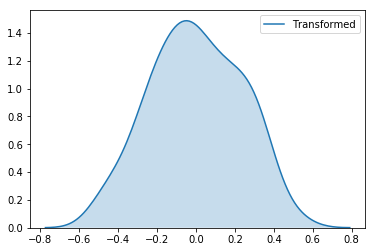

In [122]:
a1 = a1 + 0.01
at1, maxlog, interval = stats.boxcox(a1, alpha=0.05)
at1 = (at1-at1.mean())/(at1.max()-at1.min())
sns.kdeplot(at1, shade=True, label="Transformed");

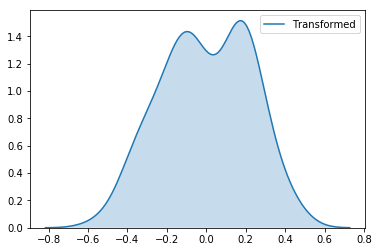

In [123]:
a2 = a2 + 0.01
at2, maxlog, interval = stats.boxcox(a2, alpha=0.05)
at2 = (at2-at2.mean())/(at2.max()-at2.min())
sns.kdeplot(at2, shade=True, label="Transformed");

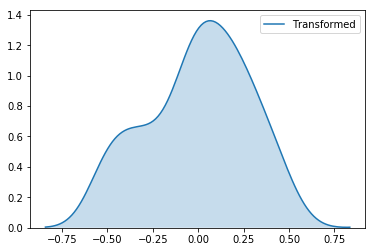

In [124]:
a3 = a3 + 0.01
at3, maxlog, interval = stats.boxcox(a3, alpha=0.05)
at3 = (at3-at3.mean())/(at3.max()-at3.min())
sns.kdeplot(at3, shade=True, label="Transformed");

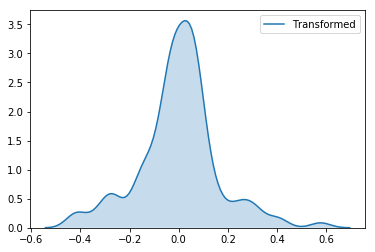

In [125]:
a4 = a4 + 0.01
at4, maxlog, interval = stats.boxcox(a4, alpha=0.05)
at4 = (at4-at4.mean())/(at4.max()-at4.min())
sns.kdeplot(at4, shade=True, label="Transformed");

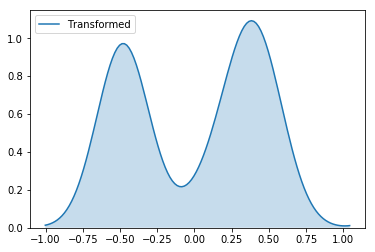

In [126]:
a5 = a5 + 0.01
at5, maxlog, interval = stats.boxcox(a5, alpha=0.05)
at5 = (at5-at5.mean())/(at5.max()-at5.min())
sns.kdeplot(at5, shade=True, label='Transformed');

In [127]:
#join transformed features into a DataFrame:
Predict_MF = pd.DataFrame()
Predict_MF['M'] = contact_MF['M']
Predict_MF['F'] = contact_MF['F']
Predict_MF['Age'] = at1
Predict_MF['Tenure'] = at2
Predict_MF['Count_CA'] = contact_MF['Count_CA']
Predict_MF['ActBal_CA']= at3
Predict_MF['VolumeCred']= at4
Predict_MF['VolumeDebCashless_Card'] = at5

# Predict possible revenue for previously identified customers:

In [128]:
#predict possible revenue (apply Random Forst Regressor):

predict_MF = pd.DataFrame(RFR.predict(Predict_MF))
predict_MF.head()

,0
0,10.249947
1,9.057325
2,12.393457
3,6.193177
4,11.746126


In [129]:
merge_MF = pd.merge(contact_2_MF, predict_MF, left_index=True, right_index=True)

In [130]:
#merge probabilita score and predicted revenue for each identified client:

merge_MF.columns = ['Client', 'Lable_MF', 'Probability', 'Pred_Revenue']
merge_MF.head(10)

,Client,Lable_MF,Probability,Pred_Revenue
0,978,1,0.900,10.249947
1,301,1,0.865,9.057325
2,579,1,0.855,12.393457
3,685,1,0.855,6.193177
4,976,1,0.830,11.746126
5,11,1,0.830,8.325133
6,1007,1,0.825,6.926473
7,1101,1,0.810,7.521538
8,223,1,0.800,6.965237
9,803,1,0.800,6.989197


In [131]:
revenue_MF = merge_MF.to_csv('~/Desktop/revenue_MF.csv')

In [132]:
#Apply the same procedure to predict revenue for identified customers for CC (Credit card) and CL (Customer loan)